# Import Stuff

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import plotly
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import csv as csv

py.init_notebook_mode(connected=True)
%matplotlib inline
%matplotlib notebook

In [3]:

btc = pd.read_csv('bitcoinprices.txt', names=['Time', 'Price'])
btc.columns = ["Time","Price"]
sent = pd.read_csv('sentiment6.txt', names=['Time', 'Sentiment'])
sent.columns = ["Time","Sentiment"]
merged = sent.merge(btc, left_index=False, right_index=False, how="inner")
merged.to_csv('merged_data.csv')

data = pd.read_csv("merged_data.csv", index_col=False)

with open('merged_data.csv', 'r') as f_input, open('output.csv', 'w') as f_output:
    csv_output = csv.writer(f_output, delimiter = ',')

    for row in csv.reader(f_input, delimiter = ','):
        if row[2] != 'None' and row[3] != 'None':
            csv_output.writerow(row)
            
            
data = pd.read_csv("output.csv", index_col=False)

data[0:3]

,Unnamed: 0,Time,Sentiment,Price
0,0,20171114,0.380219,6565.0
1,1,20171113,0.380219,6570.0
2,2,20171112,0.380219,6241.0


In [4]:
plotly.__version__

'2.3.0'

In [5]:
# Make plotly work with Jupyter notebook using the plotly.js CDN
py.init_notebook_mode(connected=True)

btc_trace = go.Scatter(x=data['Time'], y=data['Price'], name= 'Price')
py.iplot([btc_trace])

In [6]:
sent_trace = go.Scatter(x=data['Time'], y=data['Sentiment'], name= 'Sentiment')
py.iplot([sent_trace])

In [7]:
data[0:3]

,Unnamed: 0,Time,Sentiment,Price
0,0,20171114,0.380219,6565.0
1,1,20171113,0.380219,6570.0
2,2,20171112,0.380219,6241.0


In [8]:
datag = data[['Price','Sentiment']].groupby(data['Time']).mean()
datag[0:3]

,Price,Sentiment
Time,,
20160211,379.2,0.306488
20160212,389.0,0.260142
20160213,397.7,0.304902


## Training a simple random model:

In [9]:
from sklearn.preprocessing import MinMaxScaler
values = datag['Price'].values.reshape(-1,1)
sentiment = datag['Sentiment'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = sentiment.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [10]:
sentiment[0:3]
sentiment = sentiment.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
split = train_size

449 193


In [12]:
def create_dataset(dataset, look_back, sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):
                a.append(sentiment[i].tolist()[0])
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    #print(len(dataY))
    return np.array(dataX), np.array(dataY)

### with lookback = 1 (kind of unigram)

In [13]:
look_back = 1
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size])
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)])

In [14]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

<IPython.core.display.Javascript object>


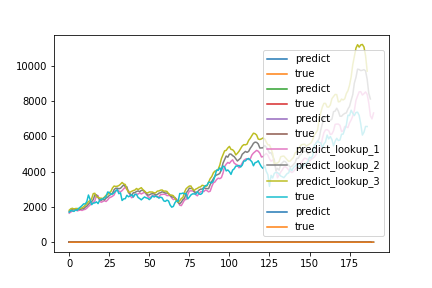

In [16]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [17]:
yhat_inverse_1 = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse_1 = scaler.inverse_transform(testY.reshape(-1, 1))

In [18]:
rmse_1 = sqrt(mean_squared_error(testY_inverse_1, yhat_inverse_1))
print('Test RMSE: %.3f' % rmse_1)

Test RMSE: 445.701


In [19]:
model_1 = model

### with lookback = 2(kind of biram)

In [20]:
look_back = 2
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size])
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)])

In [21]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [23]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [24]:
yhat_inverse_2 = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse_2 = scaler.inverse_transform(testY.reshape(-1, 1))

In [25]:
rmse_2 = sqrt(mean_squared_error(testY_inverse_2, yhat_inverse_2))
print('Test RMSE: %.3f' % rmse_2)

Test RMSE: 889.655


In [26]:
model2 = model

## With lookback = 3

In [27]:
look_back = 3
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size])
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)])

In [28]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [30]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [31]:
yhat_inverse_3 = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse_3 = scaler.inverse_transform(testY.reshape(-1, 1))

In [32]:
rmse_3 = sqrt(mean_squared_error(testY_inverse_3, yhat_inverse_3))
print('Test RMSE: %.3f' % rmse_3)

Test RMSE: 1342.602


In [33]:
model3 = model

## Plotting different lookups

In [34]:
pyplot.plot(yhat_inverse_1, label='predict_lookup_1')
pyplot.plot(yhat_inverse_2, label='predict_lookup_2')
pyplot.plot(yhat_inverse_3, label='predict_lookup_3')
pyplot.plot(testY_inverse_3, label='true')
pyplot.legend()
pyplot.show()

In [35]:
len(datag.index.values)

642

In [36]:
print(len(train), len(test))

449 193


In [37]:
btc_1_trace = go.Scatter(x=datag.index.values[len(train)-len(yhat_inverse_1):], y=yhat_inverse_1.reshape(len(yhat_inverse_1)), name= 'predict_lookup_1')
btc_2_trace = go.Scatter(x=datag.index.values[len(train)-len(yhat_inverse_2):], y=yhat_inverse_2.reshape(len(yhat_inverse_2)), name= 'predict_lookup_2')
btc_3_trace = go.Scatter(x=datag.index.values[len(train)-len(yhat_inverse_3):], y=yhat_inverse_3.reshape(len(yhat_inverse_3)), name= 'predict_lookup_3')
btc_t_trace = go.Scatter(x=datag.index.values[len(train)-len(yhat_inverse_1):], y=testY_inverse_1.reshape(len(yhat_inverse_1)), name= 'True')
py.iplot([btc_1_trace,btc_2_trace, btc_3_trace, btc_t_trace])

# With sentiment and lookup2

In [38]:
look_back = 2
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size],sent=True)
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)], sent=True)

In [39]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [40]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [41]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [42]:
yhat_inverse_sent = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse_sent = scaler.inverse_transform(testY.reshape(-1, 1))

In [43]:
rmse_sent = sqrt(mean_squared_error(testY_inverse_sent, yhat_inverse_sent))
print('Test RMSE: %.3f' % rmse_sent)

Test RMSE: 959.037


In [44]:
len(yhat)

189

In [47]:
print(len(trainX), len(testX))

445 189


In [48]:
btc_1_trace = go.Scatter(x=datag.index.values[len(trainX)-len(yhat_inverse_sent):][0:500], y=yhat_inverse_sent.reshape(len(yhat_inverse_sent))[0:500], name= 'With_Sentiment')
btc_2_trace = go.Scatter(x=datag.index.values[len(trainX)-len(yhat_inverse_1):][0:500], y=yhat_inverse_1.reshape(len(yhat_inverse_1))[0:500], name= 'No_Sentiment')
btc_3_trace = go.Scatter(x=datag.index.values[len(trainX)-len(testY_inverse_sent):][0:500], y=testY_inverse_sent.reshape(len(testY_inverse_sent))[0:500], name= 'True')
py.iplot([btc_1_trace,btc_2_trace,btc_3_trace])

In [49]:
model_sent = model

## Now go live with the model:

In [50]:
import MySQLdb
#Enter the values for you database connection
dsn_database = "bitcoin"         # e.g. "MySQLdbtest"
dsn_hostname = "173.194.231.244"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                  # e.g. 3306 
dsn_uid = "demo"             # e.g. "user1"
dsn_pwd = "qwerty@123"              # e.g. "Password123"

ImportError: No module named 'MySQLdb'

In [68]:
conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)

In [69]:
cursor=conn.cursor()
cursor.execute("""SELECT * FROM live_data""")
cursor.fetchone()

(1234.0, 123.0, 456.0, datetime.date(2009, 2, 2))

In [70]:
print ("\nShow me the records:\n")
rows = cursor.fetchall()
import pprint
pprint.pprint(rows)


Show me the records:

()


In [71]:
cursor.execute("""INSERT INTO live_data values(15625,16000,0.8,'1000-01-01 00:00:00');""")

1

In [73]:
conn.commit()

In [66]:
cursor.close()

In [172]:
# develop a real time pipeline

In [27]:
import queue 
import time
import matplotlib

In [28]:
matplotlib.__version__

'2.1.0'

In [84]:
import queue
import matplotlib.pyplot as plt
true_q = queue.Queue()
pred_q = queue.Queue()
'''
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()
plt.ion()
'''

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)
prev = 15000
threshold = 0.5
while True:
    btc = open('live_bitcoin.csv','r')
    sent = open('live_tweet.csv','r')
    bit_data = btc.readlines()
    sent_data = sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    sent_data = process_data(sent_data[len(sent_data)-5:])
    live = scaler.transform(bit_data)
    testX, testY = create_dataset(live, 2, sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    val = 100*((yhat_inverse[0][0] - prev)/prev)
    if val > threshold:
        decision = 'buy'
    elif val <-threshold:
        decision = 'sell'
    else:
        decision = ''
    prev = yhat_inverse[0][0]
    input_string = "INSERT INTO live_data values ({},{},{},'{}','{}');".format(yhat_inverse[0][0],bit_data[0][0],sent_data[4][0],datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S '),decision)
    cursor.execute(input_string)
    conn.commit()
    time.sleep(60)
    '''
    if true_q.qsize() > 9:
        true_q.get()
        pred_q.get()
        ax.clear()
        ax.plot()
        ax.plot(list(true_q.queue),'-',label='True')
        ax.plot(list(pred_q.queue),'--',label='Predict')
        ax.legend()
        fig.canvas.draw()
        time.sleep(60)
    ''' 
        

KeyboardInterrupt: 

In [75]:
import datetime
datetime.datetime.now()

datetime.datetime(2017, 12, 13, 21, 49, 54, 337601)